# Gaussian process regression

[Bayesian linear regression](bayesian_regression.ipynb) derived linear regression in a Bayesian context. Here, we discuss Gaussian process regression using `GPy` and `scipy`. Most of the material is from [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/). I also recommend Michael Betancourt's [Robust Gaussian Processes in Stan](https://betanalpha.github.io/assets/case_studies/gp_part1/part1.html) as a resource, for instance to learn more about hyperparameter inference which won't be covered here.

As usual **I do not take warranty for the correctness or completeness of this document.**

In [1]:
import GPy
import scipy
from sklearn.metrics.pairwise import rbf_kernel

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

In [2]:
rnorm = scipy.stats.norm.rvs
mvrnorm = scipy.stats.multivariate_normal.rvs

### Priors on functions

In Bayesian linear regression we assumed a linear dependency

\begin{align*}
f_{\boldsymbol \beta}& :  \ \mathcal{X} \rightarrow \mathcal{Y},\\
f_{\boldsymbol \beta}(\mathbf{x}) & =  \ \mathbf{x}^T \boldsymbol \beta + \epsilon,
\end{align*}

which was parametrized by a coefficient vector $\boldsymbol \beta$. 
In order to model uncertainty, regularize our coeffiencts, or what reason whatsoever, we put a prior distribution on $\boldsymbol \beta$ and by that introduced some prior belief to the model.

When we use Gaussian Processes, we instead set a prior on the function $f$ itself:

\begin{align*}
f(\mathbf{x}) & \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) ,\\
p(f \mid \mathbf{x}) & = \mathcal{N}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) .
\end{align*}

So a Gaussian process is a distribution of functions. It is parametrized by a *mean function* $m$ that returns a vector of length $n$ and a *kernel function* $k$ that returns a matrix of dimension $n \times n$, where $n$ is the number of samples. For instance, the mean function could be a constant (which we will assume throughout the rest of this notebook), and the kernel could be a radial basis function, i.e.:

\begin{align*}
m(\mathbf{x}) &= \mathbf{0},\\
k(\mathbf{x}, \mathbf{x}') &= \exp\left(- \gamma ||\mathbf{x} - \mathbf{x}' ||^2 \right),
\end{align*}

where $\gamma$ a hyperparameter we have to optimize. 


The parameters $\mathbf{m}$ and $\mathbf{k}$  apparently do not have a fixed dimensionality as in Bayesian linear regression (where we had $\boldsymbol \beta \in \mathbb{R}^p$), but have possibly infinite dimension. That means with more data, the dimensions of $\mathbf{m}$ and $\mathbf{k}$ increase (in Bayesian regression $\boldsymbol \beta$ was independent of the sample size $n$). For that reason we call this approach *non-parametric* (the turn itself sounds confusing, because we apparently *have* parameters).

Next, let's look at some *prior functions* $f$. A prior function is just a sample from a $n$-dimensional multivariate normal distribution with mean $\mathbf{m}$ and variance $\mathbf{k}$. The kernel must be postive definite, which the *RBF* kernel is.

In [3]:
n = 50
x = scipy.linspace(0, 1, n).reshape((n, 1))
beta = 2
y = scipy.sin(x) * beta + rnorm(size=(n, 1), scale=.1)

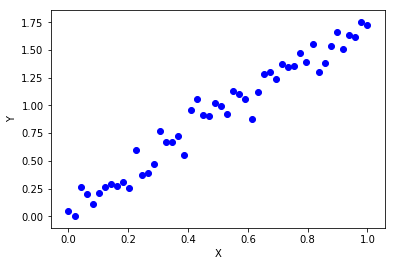

In [4]:
plt.scatter(x, y, color="blue")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Then we set the mean and covariance functions.

In [5]:
m = scipy.zeros(n)
kernel = GPy.kern.RBF(input_dim=1)

In [6]:
k = kernel.K(x, x)

Then we sample five functions from the Gaussian process:

In [7]:
f_prior = [mvrnorm(mean=m, cov=k) for i in range(5)]

...and we plot the five samples.

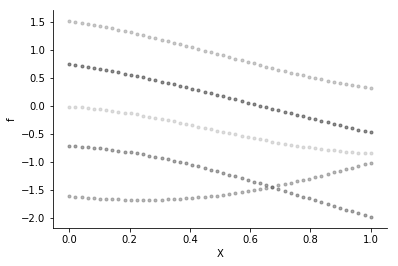

In [8]:
colors = ['#bdbdbd','#969696','#737373','#525252','#252525']
_, ax = plt.subplots()
for i in range(5):
    ax.scatter(x, f_prior[i], color=colors[i], marker=".", alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("X")
plt.ylabel("f")
plt.show()

This does not look like our data set at all. The reason is that we did not consider the responses $\mathbf{y}$ in the model. We do this by multiplying the prior with the likelihood, which gives us the posterior Gaussian process.

### Posterior Gaussian process


We haven't specified the likelihood yet which we will assume to be Gaussian:

\begin{align*}
p(\mathbf{y} \mid f, \mathbf{x}) = \prod_i^n \mathcal{N}(f_i, \sigma^2 \mathbf{I} ).
\end{align*}

Later, for classification, we will also use a binomial likelihood.

The posterior Gaussian process is given by

\begin{align*}
\text{posterior} \propto \text{likelihood} \times \text{prior}.
\end{align*}

It is easy to derive the posterior from a joint distribution of the actual observations $\mathbf{y}$ and the posterior function values:

\begin{align*}
\left[
\begin{array}{c}
\mathbf{y} \\
{f}
\end{array}
\right] \sim
\mathcal{N} \left(  \mathbf{0},
\begin{array}{cc}
 k(\mathbf{x}, \mathbf{x}')  + \sigma^2 \mathbf{I} &  k(\mathbf{x}, {\mathbf{x}}') \\
k({\mathbf{x}}, \mathbf{x}') & k({\mathbf{x}}, {\mathbf{x}}')
\end{array}
  \right).
 \end{align*}

Thus conditioning on $\mathbf{y}$ gives:


\begin{align*}
p(f \mid \mathbf{y}, \mathbf{x}) & \propto p(\mathbf{y} \mid f, \mathbf{x}) \ p(f \mid \mathbf{x}),\\
f \mid \mathbf{y}, \mathbf{x} & \sim \mathcal{GP}\left(\tilde{m}(\tilde{\mathbf{x}}), \tilde{k}({\mathbf{x}}, {\mathbf{x}}')\right),\\\\
\tilde{m}({\mathbf{x}}) & = k({\mathbf{x}}, \mathbf{x}')\left( k(\mathbf{x}, \mathbf{x}') + \sigma^2 \mathbf{I}   \right)^{-1} \mathbf{y},\\
\tilde{k}({\mathbf{x}}, {\mathbf{x}}')  & = k({\mathbf{x}}, {\mathbf{x}}') - k({\mathbf{x}}, \mathbf{x}') \left( k(\mathbf{x}, \mathbf{x}') + \sigma^2 \mathbf{I}  \right)^{-1} k(\mathbf{x}, {\mathbf{x}}')
\end{align*}

So the posterior is again a Gaussian process with modified mean and variance functions. Let's compute this analytically and then compare it to the `GPy` posterior.

In [9]:
inv = scipy.linalg.inv(k + .1 * scipy.diag(scipy.ones(n)))
m_tilde = (k.dot(inv).dot(y)).flatten()
k_tilde = k - k.dot(inv).dot(k)

Sample from the posterior:

In [10]:
f_posterior = [mvrnorm(mean=m_tilde, cov=k_tilde) for i in range(5)]

In `GPy` this is way easier, because we only need to call a single function:

In [11]:
m = GPy.models.GPRegression(x, y, kernel, noise_var=.1)
gpy_f_posterior = m.posterior_samples_f(x, full_cov=True, size=5)

Let's compare our posterior to the one from `GPy`.

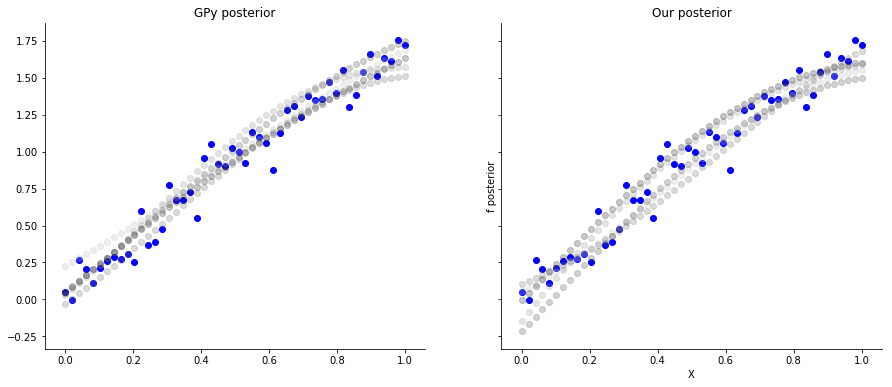

In [13]:
plt.rcParams['figure.figsize'] = [15, 6]
colors = ['#bdbdbd','#969696','#737373','#525252','#252525']
_, ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].scatter(x, y, color="blue")
ax[1].scatter(x, y, color="blue")
for i in range(5):
    ax[0].scatter(x, gpy_f_posterior[:, i], color=colors[i], alpha=0.25)
    ax[1].scatter(x, f_posterior[i], color=colors[i], alpha=0.25)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].set_title("GPy posterior")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_title("Our posterior")
plt.xlabel("X")
plt.ylabel("f posterior")
plt.show()

The are pretty much similar. However, we cheated a little, because we knew the error variance.

### Posterior predictive

We can use the same formalism as above to derive the posterior predictive distribution, i.e. the distribution of function values $f^*$ for new observations $\mathbf{x}^*$. This is useful, when we want to do prediction.

Usually the predictive posterior is given like this:

\begin{align*}
p(f^* \mid \mathbf{y}, \mathbf{x}, \mathbf{x}^*) = \int p(f^* \mid f) \ p(f \mid \mathbf{y}, \mathbf{x}),
\end{align*}

(where we included $\mathbf{x}$ for clarity). However, since our original data set $\mathbf{y}$ and $f^*$ have a joint normal distribution, we can just use Gaussian conditioning again. Later, when we are using non-normal likelihoods, we will need to come back to this formulation.

We start again by writing down the joint distribution of $\mathbf{y}$ and the unobserved function values $f^*$:

\begin{align*}
\left[
\begin{array}{c}
\mathbf{y} \\
{f}^*
\end{array}
\right] \sim
\mathcal{N} \left(  \mathbf{0},
\begin{array}{cc}
 k(\mathbf{x}, \mathbf{x}')  + \sigma^2 \mathbf{I} &  k(\mathbf{x}, {\mathbf{x}}^*) \\
k({\mathbf{x}}^*, \mathbf{x}) & k({\mathbf{x}}^*, {\mathbf{x}^*}')
\end{array}
  \right).
 \end{align*}

Conditioning on $\mathbf{y}$ yields:

\begin{align*}
f^* \mid \mathbf{y}, \mathbf{x}, \mathbf{x}^* & \sim \mathcal{GP}\left({m}^*({\mathbf{x}^*}), {k}^*({\mathbf{x}^*}, {\mathbf{x}^*}')\right),\\\\
{m}^*({\mathbf{x}^*}) & = k({\mathbf{x}^*}, \mathbf{x})\left( k(\mathbf{x}, \mathbf{x}') + \sigma^2 \mathbf{I}   \right)^{-1} \mathbf{y},\\
{k}^*({\mathbf{x}^*}, {\mathbf{x}^*}')  & = k({\mathbf{x}^*}, {\mathbf{x}^*}') - k({\mathbf{x}^*}, \mathbf{x}) \left( k(\mathbf{x}, \mathbf{x}') + \sigma^2 \mathbf{I}  \right)^{-1} k(\mathbf{x}, {\mathbf{x}^*}).
\end{align*}

This is the exact same formulation as above, only that we replaced some of the old data with the new data $\mathbf{x}^*$.

### Prediction

Now that the theory is established, we optimize the kernel parameters using `m.optimize()`, such that the appropriately fit the data. Then we predict the responses $\hat{\mathbf{y}}$ using our trained Gaussian process.

It does not make too much sense to predict the already known values $f$, but posterior predictive checks are always a quick way to check model assumptions.

In [14]:
m.optimize() 
y_hat = m.predict(x)

... and plot it again.

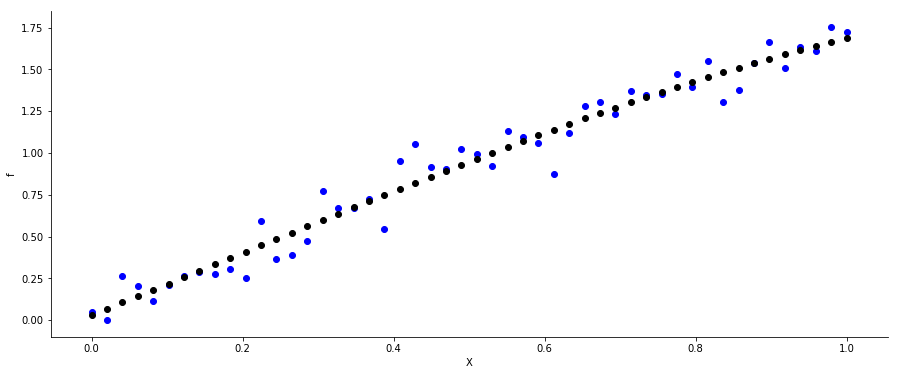

In [15]:
_, ax = plt.subplots()
ax.scatter(x, y, color="blue")
ax.scatter(x, y_hat[0], color="black")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel("X")
plt.ylabel("f")
plt.show()